In [44]:
import os 
import json 
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cbook as cbook
#from scipy.misc import imread
from matplotlib.pyplot import imread

from tqdm import tqdm_notebook

In [3]:
pd.options.display.max_colwidth = 400

sns.set()

#### Load sloth jsons into array of pandas dataframes

In [4]:
def loadJSONintoDF(filepath):
    assert (os.path.isfile(filepath)) # check if file path exists
    annos = json.load( open(filepath, 'r') )[0]['annotations']
    df = pd.DataFrame(annos)
    return df

def loadAllJSONSFromPath(datapath):
    assert (os.path.isdir(datapath)) # check if datapath is directory
    json_files = [pos_json for pos_json in os.listdir(datapath) if pos_json.endswith('.json')]
    
    #df_stats = pd.DataFrame(columns=['filename', '#fish', '#fish2', '#fish3'])
    all_df = []
    
    for filename in json_files:
        #df_stats = df_stats.append({'filename' : filename} , ignore_index=True)
        all_df.append(loadJSONintoDF(datapath + filename))
    df_stats = pd.DataFrame(0, index=json_files, columns=['#fish', '#fish2', '#fish3'])
    df_stats['#fish'] = 0
    df_stats['#fish2'] = 0
    df_stats['#fish3'] = 0
    df_stats['#allfishes'] = 0
    
    #print(json_files)
    
    return df_stats, all_df, json_files

In [5]:
# test loading one json file
f_name = './data/IMG_5666_annotations_al.json'
df = loadJSONintoDF(f_name)

print(df.head(1))

  class                          xn                           yn
0  fish  726.77710788;495.185329587  79.1622805803;108.637597818


In [13]:
# load all json files from datapath into array of pandas dataframes
df_stats, all_df, json_files = loadAllJSONSFromPath('./data/20191031_MIxedSpecies_Photos_final_annotations/')
print('Number of json files loaded: ' + str(len(all_df)))

Number of json files loaded: 154


#### Abundance of classes

In [10]:
def calcNumberOfClasses(df):

    
    classes = ['fish', 'fish_2', 'fish_3']
    dfout = pd.DataFrame()
    class_ab = [0,0,0]
    
    for i, cla in enumerate(classes):
        class_ab[i] = len( df.loc[df['class'] == cla])
    return class_ab
             
    #classes = np.unique(df[xxx].values)                      
    #dfout[xxx] = pd.Series(classes)
    #dfout['abundance'] = pd.Series( np.zeros(len(classes)) )

    #for i, cla in enumerate(classes):
    #    dfout.loc[dfout[xxx] == cla, 'abundance'] = len( df.loc[df[xxx] == cla] )

    #all_sum = dfout['abundance'].sum()
    #dfout['all_sum'] = all_sum

In [57]:
# add number of classes to data statistics
for i, df in enumerate(all_df):
    df_nclasses = calcNumberOfClasses(df)
    #df_stats.iloc[i]
    #df_stats['#fish'].iloc[i] = df_nclasses[0]
    #df_stats['#fish2'].iloc[i] = df_nclasses[1]
    #df_stats['#fish3'].iloc[i] = df_nclasses[2]
    df_stats.at[json_files[i], '#fish'] = df_nclasses[0]
    df_stats.at[json_files[i], '#fish2'] = df_nclasses[1]
    df_stats.at[json_files[i], '#fish3'] = df_nclasses[2]
    df_stats.at[json_files[i], '#allfishes'] = sum(df_nclasses)

#df_stats[['#fish', '#fish2', '#fish3']].iloc[0]
df_stats.head(3)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_stats)

                                 #fish  #fish2  #fish3  #allfishes  \
IMG_5529_annotations_al.json       136       0       0         136   
IMG_5587_annotations_al.json         9       6       0          15   
IMG_5590_annotations_al.json        13       9       0          22   
IMG_5616_annotations_al_jl.json    141      15       1         157   
IMG_5643_annotations_al_jl.json    157      19       3         179   
IMG_5666_annotations_al_jl.json    166       0       0         166   
IMG_5673_annotations_al_jl.json    137       0       0         137   
IMG_5681_annotations_al_jl.json    261       0       0         261   
IMG_5688_annotations_al_jl.json     67       0       1          68   
IMG_5693_annotations_al_jl.json     78       0       0          78   
IMG_5699_annotations_al_jl.json     42       1       0          43   
IMG_5701_annotations_al_jl.json    150       1       0         151   
IMG_5712_annotations_al_jl.json    169       0       0         169   
IMG_5718_annotations

#### Description of dataframe df_stats

In [12]:
#df.describe()
df_stats.describe()

,#fish,#fish2,#fish3,#allfishes
count,154.000000,154.000000,154.000000,154.000000
mean,78.266234,6.701299,1.415584,86.383117
std,69.236645,12.612956,4.866454,66.864627
min,0.000000,0.000000,0.000000,8.000000
25%,25.000000,0.000000,0.000000,38.750000
50%,60.000000,1.000000,0.000000,67.000000
75%,112.000000,6.000000,1.000000,116.500000
max,332.000000,63.000000,38.000000,332.000000


#### Split positions + Average pos column + length column

In [14]:
'''
sloth annotation has xn and yn with
xn = xhead;xtail
yn = yhead;ytail
this fctn. splits the yn and xn to new columns in the dataframe
'''
df_allsplit = []

for df in all_df:
    df_split = df.copy()

    xn = np.array([ np.array(xn.split(';'), dtype=float) for xn in df['xn']])
    df_split['xhead'] = pd.Series( xn[:, 0] )
    df_split['xtail'] = pd.Series( xn[:, 1] )
    yn = np.array([ np.array(yn.split(';'), dtype=float) for yn in df['yn']])
    df_split['yhead'] = pd.Series( yn[:, 0] )
    df_split['ytail'] = pd.Series( yn[:, 1] )

    if 'xn' in df_split.columns and 'yn' in df_split.columns:
        df_split = df_split.drop(['xn', 'yn'], axis = 1)

    # add average position ((pos_head + pos_tail) / 2) column
    df_split['x_av'] = (df_split['xhead'] + df_split['xtail']) / 2
    df_split['y_av'] = (df_split['yhead'] + df_split['ytail']) / 2

    # add length column
    df_split['len'] = np.sqrt(np.power(df_split['xhead'] - df_split['xtail'], 2) + np.power(df_split['yhead']- df_split['ytail'], 2))

    #print(df_split.head(1))
    
    df_allsplit.append(df_split)
assert(len(df_allsplit) == len(json_files))

print(df_allsplit[0].head(2))

  class   xhead   xtail   yhead   ytail     x_av     y_av         len
0  fish  465.30  166.38  314.43  265.08  315.840  289.755  302.966316
1  fish  813.57  547.08  197.40  253.80  680.325  225.600  272.392878


#### Plot avg. positions

In [23]:
def plot_with_cat(df_split, imgpath, number, show=True, save=False):

#     #https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category

#     plt.close('all')

#     fig, ax = plt.subplots()
#     groups = df_split.groupby('class')

#     for name, group in groups:
#         ax.plot(group.x_av, group.y_av, marker='o', linestyle='', ms=8, label=name)

#     ax.legend(loc = 'best')
#     plt.gca().invert_yaxis()
    
#     if(save):
#         plt.savefig(os.path.join("./output/plots/", str(number)+'_pos'))
#     if(show):
#         plt.show()

    # show plot with corresponding image
    plt.close('all')

    fig, ax = plt.subplots()

    #datafile = cbook.get_sample_data('./data/IMG_5666.jpg')
    #img = imread(datafile)
    im = plt.imread(imgpath)
    implot = plt.imshow(im)

    groups = df_split.groupby('class')

    for name, group in groups:
        ax.plot(group.x_av, group.y_av, marker='o', linestyle='', ms=5, label=name)

    #plt.gca().invert_yaxis()
    plt.rcParams['figure.figsize'] = (20,10)
    
    if(save):
        plt.savefig(os.path.join("./output/plots", str(number)+"_pos_img"))
    if(show):
        plt.show()
    
    print(f"Plotted positions on image {number}: {imgpath}")

#### Find path of image linked to json

In [37]:
# this only works with this format: IMG_XXXX_annotations_al.json and IMG_XXXX.jpg
def get_imgpath_for_json(filename):
    #print(filename)
    
    number = filename[4:8]
        
    all_imgdir = './data/images/'
    imgfiles = [img_name for img_name in os.listdir(all_imgdir) if img_name.endswith('.jpg')]
    
    found_file = -1
    
    for name in imgfiles:
        if name[4: -4] == number:
            found_file = name
    assert(found_file != -1)
    
    imgpath = all_imgdir + found_file
    
    assert (os.path.isfile(imgpath))
    
    
    return imgpath, number

#### Plot heads + tails -> shows orientation

In [24]:
#https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
def plot_cat_with_ori(df_split, imgpath, number, show=True, save=False):
    plt.close('all')

    fig, ax = plt.subplots()
    groups = df_split.groupby('class')

    for name, group in groups:
        #print(group.shape)
        ax.plot(group.xhead, group.yhead, marker='o', linestyle='', ms=10, label=name)

        #ax.plot(group.xtail, group.ytail, marker='x', linestyle='', ms=10, label=name)

    df_plot = df_split.copy()[['xhead', 'ytail', 'yhead' , 'xtail']]
    for index, fish in df_plot.iterrows():
        ax.plot([fish[0],fish[3]], [fish[2],fish[1]], marker='o', linestyle='-', ms=1, color= 'Black')   

    ax.legend(loc = 'best')

    plt.gca().invert_yaxis()

    if(save):
        plt.savefig(os.path.join("./output/plots/", str(number)+'_ori'))
    if(show):
        plt.show()
        
    print(f"Plotted positions and orientations {number}")
    
#     #orientation plot on image
#     plt.close('all')

#     fig, ax = plt.subplots()
#     groups = df_split.groupby('class')

#     for name, group in groups:
#         #print(group.shape)
#         ax.plot(group.xhead, group.yhead, marker='o', linestyle='', ms=10, label=name)

#         #ax.plot(group.xtail, group.ytail, marker='x', linestyle='', ms=10, label=name)

#     df_plot = df_split.copy()[['xhead', 'ytail', 'yhead' , 'xtail']]
#     for index, fish in df_plot.iterrows():
#         ax.plot([fish[0],fish[3]], [fish[2],fish[1]], marker='o', linestyle='-', ms=1, color= 'Black')   

#     ax.legend(loc = 'best')

#     plt.gca().invert_yaxis()
    
#     im = plt.imread(imgpath)
#     implot = plt.imshow(im)
    
#     if(save):
#         plt.savefig(os.path.join("./output/plots", str(number)+"_ori_img"))
#     if(show):
#         plt.show()

IMG_5666_annotations_al_jl.json


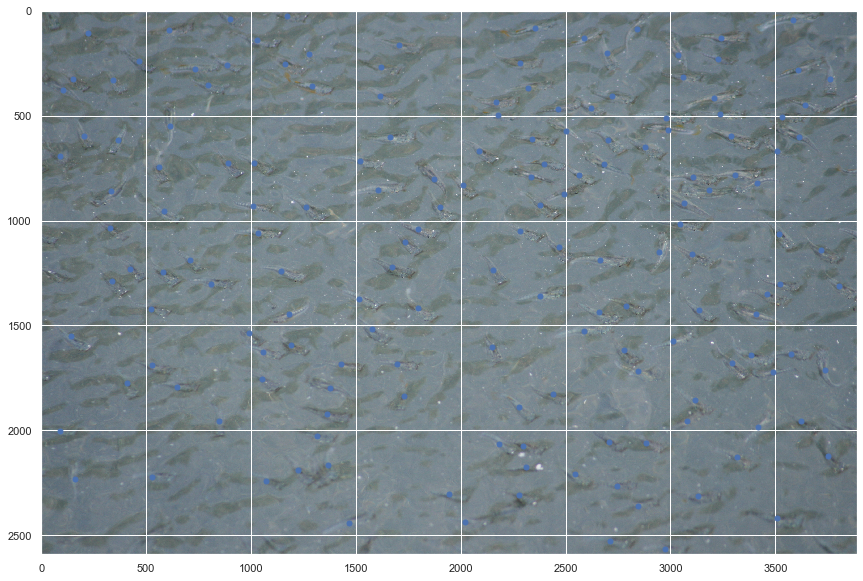

Plotted positions on image 5666: ./data/images/IMG_5666.jpg


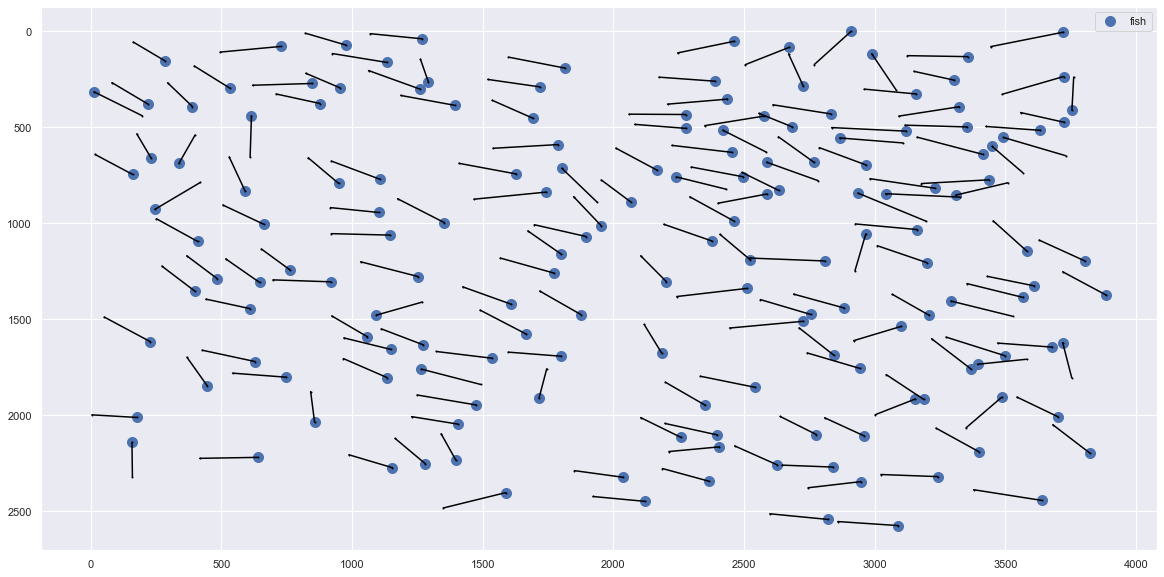

Plotted positions and orientations 5666


In [35]:
#test

index=5
#print(json_files)

imgpath, number = get_imgpath_for_json(json_files[index])
plot_with_cat(df_allsplit[index],imgpath, number, show=True, save=True)
plot_cat_with_ori(df_allsplit[index],imgpath, number, show=True, save=True)

In [38]:
#get all numbers and imgpaths
data_numbers = []
img_paths = []

for json in json_files:
    imgpath, number = get_imgpath_for_json(json)
    img_paths.append(imgpath)
    data_numbers.append(number)

Plotted positions on image 5529: ./data/images/IMG_5529.jpg
Plotted positions and orientations 5529
Plotted positions on image 5587: ./data/images/IMG_5587.jpg
Plotted positions and orientations 5587
Plotted positions on image 5590: ./data/images/IMG_5590.jpg
Plotted positions and orientations 5590
Plotted positions on image 5616: ./data/images/IMG_5616.jpg
Plotted positions and orientations 5616
Plotted positions on image 5643: ./data/images/IMG_5643.jpg


KeyboardInterrupt: 

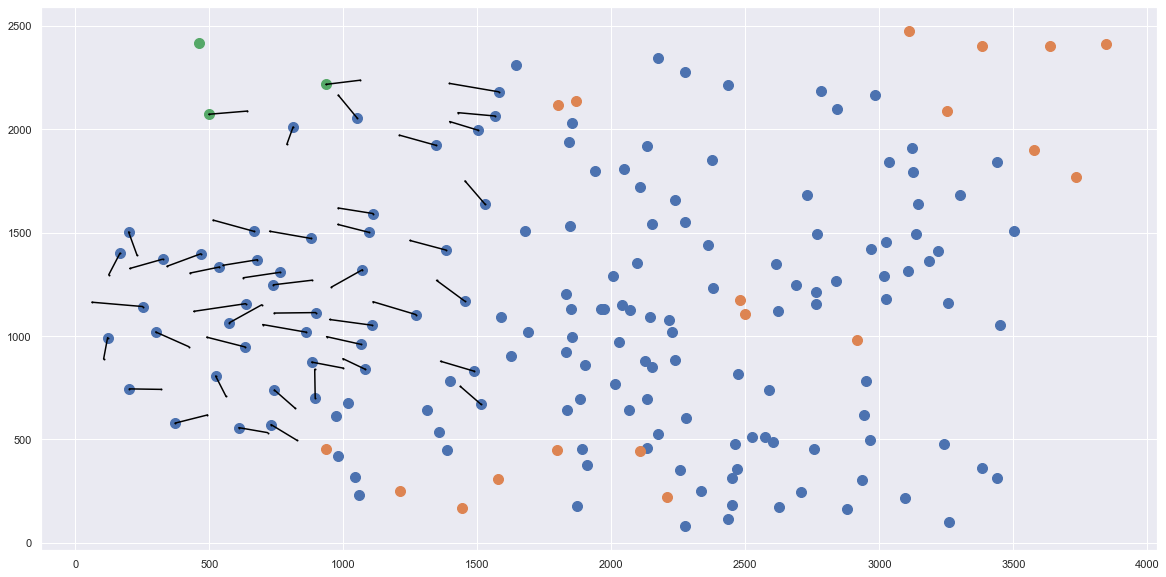

In [45]:
# generate plots for all datasets

for i, dfsplit in enumerate(tqdm_notebook(df_allsplit)):
    plot_with_cat(dfsplit, img_paths[i], data_numbers[i], show=False, save=True)
    plot_cat_with_ori(dfsplit, img_paths[i], data_numbers[i], show=False, save=True)

#### Distance matrix + neighbors

In [46]:
def calc_neighbors(df_split):
    df_pos_av = df_split[['x_av', 'y_av']]

    dist_m = distance_matrix(df_pos_av, df_pos_av)
    df_dist_m = pd.DataFrame(dist_m)
    
    #find neighbours in distance matrix
    avg_length = df_split['len'].mean()
    dist1 = avg_length * 2;
    dist2 = avg_length * 4;

    print("Distance1: {} , Distance2: {} ".format(dist1, dist2))

    #neighbors in distance average length*2
    df_dist_m_2 = df_dist_m[df_dist_m < dist1]
    df_dist_m_2 = df_dist_m_2[df_dist_m_2 != 0]
    assert(df_dist_m_2.shape[0] == df_split.shape[0])  #this should be the same as before

    np_dists = df_dist_m_2.values
    np_neighbor_pairs = np.argwhere(~np.isnan(np_dists))
    #np_neighbors2 = np.split(np_neighbor_pairs[:, 1], np.cumsum(np.unique(np_neighbor_pairs[:, 0], return_counts=True)[1])[:-1]) #https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function

    #setup neighbors
    np_neighbors2 = []
    for i_fish in range(df_dist_m_2.shape[0]):
        np_neighbors2.append([])
    #fill neighbors
    for neighbor_pair in np_neighbor_pairs:
        np_neighbors2[neighbor_pair[0]].append(neighbor_pair[1])
        
    assert(len(np_neighbors2) == df_split.shape[0])
    df_split['nb_av2'] = np_neighbors2

    #neighbors in distance average length*4
    df_dist_m_4 = df_dist_m[df_dist_m < dist2]
    df_dist_m_4 = df_dist_m_4[df_dist_m_4 != 0]
    assert(df_dist_m_4.shape[0] == df_split.shape[0])  #this should be the same as before

    np_dists = df_dist_m_4.values
    np_neighbor_pairs = np.argwhere(~np.isnan(np_dists))
    #np_neighbors4 = np.split(np_neighbor_pairs[:, 1], np.cumsum(np.unique(np_neighbor_pairs[:, 0], return_counts=True)[1])[:-1])    #https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function

    #setup neighbors
    np_neighbors4 = []
    for i_fish in range(df_dist_m_4.shape[0]):
        np_neighbors4.append([])
    #fill neighbors
    for neighbor_pair in np_neighbor_pairs:
        np_neighbors4[neighbor_pair[0]].append(neighbor_pair[1])
    
    assert(len(np_neighbors2) == df_split.shape[0])
    df_split['nb_av4'] = np_neighbors4



In [47]:
# test
calc_neighbors(df_allsplit[1])
df_allsplit[1].head(1)

Distance1: 376.0055147877184 , Distance2: 752.0110295754369 


,class,xhead,xtail,yhead,ytail,x_av,y_av,len,nb_av2,nb_av4
0,fish_2,454.787302,607.966315,1058.00388,1225.432103,531.376808,1141.717992,226.927345,[],[13]


In [48]:
#calculate neighbors for all datasets
for df_split in df_allsplit:
    calc_neighbors(df_split)
df_allsplit[64].head(2)

Distance1: 469.0345477634149 , Distance2: 938.0690955268298 
Distance1: 376.0055147877184 , Distance2: 752.0110295754369 
Distance1: 400.3987155303914 , Distance2: 800.7974310607829 
Distance1: 275.3759024988521 , Distance2: 550.7518049977042 
Distance1: 259.67581297507695 , Distance2: 519.3516259501539 
Distance1: 409.5641663379435 , Distance2: 819.128332675887 
Distance1: 497.6771245504339 , Distance2: 995.3542491008678 
Distance1: 430.66943860693044 , Distance2: 861.3388772138609 
Distance1: 473.6156670811038 , Distance2: 947.2313341622076 
Distance1: 425.80586223270205 , Distance2: 851.6117244654041 
Distance1: 421.571547329185 , Distance2: 843.14309465837 
Distance1: 427.8895799613867 , Distance2: 855.7791599227734 
Distance1: 419.00171610905824 , Distance2: 838.0034322181165 
Distance1: 388.2520545425786 , Distance2: 776.5041090851572 
Distance1: 431.39630204664303 , Distance2: 862.7926040932861 
Distance1: 449.5316872498808 , Distance2: 899.0633744997616 
Distance1: 386.94898837

,class,xhead,xtail,yhead,ytail,x_av,y_av,len,nb_av2,nb_av4
0,fish,54.720969,108.169357,262.151619,137.438713,81.445163,199.795166,135.683600,"[1, 10]","[1, 2, 3, 8, 9, 10, 11, 12, 14]"
1,fish,305.419362,302.874201,48.358066,213.793553,304.146781,131.075810,165.455065,"[0, 2, 10]","[0, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15]"


#### Add number of class neighbors column

In [49]:
def calc_class_neighbors(df_split):
    
    # get classes of neighbors
    neighbor_list_f = []
    neighbor_list_f2 = []
    neighbor_list_f3 = []
    
    np_neighbors2 = df_split["nb_av2"].tolist()
    np_neighbors4 = df_split["nb_av4"].tolist()

    assert (len(np_neighbors2) == df_split.shape[0])
    assert (len(np_neighbors4) == df_split.shape[0])

    #count neighbors for dist1 = av * 2
    for nl in np_neighbors2:
        neighbors_f = []
        neighbors_f2 = []
        neighbors_f3 = []

        for n in nl:
            switch = (df_split['class'][n])
            if switch =='fish':
                neighbors_f.append(n)
            elif switch == 'fish_2':
                neighbors_f2.append(n)
            elif switch == 'fish_3':
                neighbors_f3.append(n)

        neighbor_list_f.append(neighbors_f)
        neighbor_list_f2.append(neighbors_f2)
        neighbor_list_f3.append(neighbors_f3)

    # count neighbors
    neighbor_numbers_f = [len(n) for n in neighbor_list_f]
    neighbor_numbers_f2 = [len(n) for n in neighbor_list_f2]
    neighbor_numbers_f3 = [len(n) for n in neighbor_list_f3]

    # add class neighbor list to df
    df_split['#neighbors_d2_f'] = neighbor_numbers_f
    df_split['#neighbors_d2_f2'] = neighbor_numbers_f2
    df_split['#neighbors_d2_f3'] = neighbor_numbers_f3

    #############
    #############

    #count neighbors for dist2 = av * 4
    neighbor_list_d4_f = []
    neighbor_list_d4_f2 = []
    neighbor_list_d4_f3 = []

    for nl in np_neighbors4:
        neighbors_d4_f = []
        neighbors_d4_f2 = []
        neighbors_d4_f3 = []

        for n in nl:
            switch = (df_split['class'][n])
            if switch =='fish':
                neighbors_d4_f.append(n)
            elif switch == 'fish_2':
                neighbors_d4_f2.append(n)
            elif switch == 'fish_3':
                neighbors_d4_f3.append(n)

        neighbor_list_d4_f.append(neighbors_d4_f)
        neighbor_list_d4_f2.append(neighbors_d4_f2)
        neighbor_list_d4_f3.append(neighbors_d4_f3)

    # count neighbors
    neighbor_numbers_f = [len(n) for n in neighbor_list_d4_f]
    neighbor_numbers_f2 = [len(n) for n in neighbor_list_d4_f2]
    neighbor_numbers_f3 = [len(n) for n in neighbor_list_d4_f3]

    # add class neighbor list to df
    df_split['#neighbors_d4_f'] = neighbor_numbers_f
    df_split['#neighbors_d4_f2'] = neighbor_numbers_f2
    df_split['#neighbors_d4_f3'] = neighbor_numbers_f3

In [50]:
#test
calc_class_neighbors(df_allsplit[0])
df_allsplit[0].head(1)

,class,xhead,xtail,yhead,ytail,x_av,y_av,len,nb_av2,nb_av4,#neighbors_d2_f,#neighbors_d2_f2,#neighbors_d2_f3,#neighbors_d4_f,#neighbors_d4_f2,#neighbors_d4_f3
0,fish,465.3,166.38,314.43,265.08,315.84,289.755,302.966316,"[1, 4, 5, 133]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 131, 132, 133]",4,0,0,14,0,0


In [56]:
# calc class neighbors for all df
for df_split in tqdm_notebook(df_allsplit):
    calc_class_neighbors(df_split)
df_allsplit[64].head(2)

,class,xhead,xtail,yhead,ytail,x_av,y_av,len,nb_av2,nb_av4,#neighbors_d2_f,#neighbors_d2_f2,#neighbors_d2_f3,#neighbors_d4_f,#neighbors_d4_f2,#neighbors_d4_f3
0,fish,54.720969,108.169357,262.151619,137.438713,81.445163,199.795166,135.683600,"[1, 10]","[1, 2, 3, 8, 9, 10, 11, 12, 14]",2,0,0,9,0,0
1,fish,305.419362,302.874201,48.358066,213.793553,304.146781,131.075810,165.455065,"[0, 2, 10]","[0, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15]",3,0,0,11,0,0


#### Add average length to stats

In [53]:
all_avg_len = []
for idf, df_split in enumerate(tqdm_notebook(df_allsplit)):
    all_avg_len.append(df_split['len'].mean())
assert(len(all_avg_len) == df_stats.shape[0])
df_stats["avg_len"] = all_avg_len

df_stats.head(3)

,#fish,#fish2,#fish3,#allfishes,avg_len
IMG_5529_annotations_al.json,0,0,0,0,234.517274
IMG_5587_annotations_al.json,0,0,0,0,188.002757
IMG_5590_annotations_al.json,0,0,0,0,200.199358


#### Add same class neighbors percentage and average number of neighbors (per class and total) to stats 

In [58]:
allf_same = []
allf2_same = []
allf3_same = []

avg_total_n = []
avg_ff_n = []
avg_f2f2_n = []
avg_f3f3_n = []

for i, df_split in enumerate(df_allsplit):
    
    p_f_same = 0
    p_f2_same = 0
    p_f3_same = 0
    
    avg_f_same = 0
    avg_f2_same = 0
    avg_f3_same = 0
    
    num_f = df_stats["#fish"][i]
    num_f2 = df_stats["#fish2"][i]
    num_f3 = df_stats["#fish3"][i]
    
    avg_n_len = 0
    
    # calculate average number of neighbors of same class of fish by all neighbors of fish per class and append to list of images
    # also calculate average number of same class neighbors and total neighbors
    for i in df_split.index:
        #avg number of same class neighbors and percentual
        c = df_split.at[i, "class"]
        neighbors_len = len(df_split.at[i, "nb_av2"])
        
        avg_n_len += neighbors_len
        
        if(neighbors_len == 0):
            continue
        
        if(c == "fish"):
            p_f_same += df_split.at[i, "#neighbors_d2_f"] / neighbors_len
            avg_f_same += df_split.at[i, "#neighbors_d2_f"]
        elif(c == "fish_2"):
            p_f2_same += df_split.at[i, "#neighbors_d2_f2"] / neighbors_len
            avg_f2_same += df_split.at[i, "#neighbors_d2_f2"]
        elif(c == "fish_3"):
            p_f3_same += df_split.at[i, "#neighbors_d2_f3"] / neighbors_len
            avg_f3_same += df_split.at[i, "#neighbors_d2_f3"]
    
    allf_same.append(p_f_same/num_f if num_f != 0 else 0)
    allf2_same.append(p_f2_same/num_f2 if num_f2 != 0 else 0)
    allf3_same.append(p_f3_same/num_f3 if num_f3 != 0 else 0)
    
    avg_total_n.append(avg_n_len/df_split.shape[0] if df_split.shape[0] != 0 else 0)
    avg_ff_n.append(avg_f_same/num_f if num_f != 0 else 0)
    avg_f2f2_n.append(avg_f2_same/num_f2 if num_f2 != 0 else 0)
    avg_f3f3_n.append(avg_f3_same/num_f3 if num_f3 != 0 else 0)
    

df_stats["av2_f_same"] = allf_same
df_stats["av2_f2_same"] = allf2_same
df_stats["av2_f3_same"] = allf3_same

df_stats["av2_avg_n_total"] = avg_total_n
df_stats["av2_avg_n_f"] = avg_ff_n
df_stats["av2_avg_n_f2"] = avg_f2f2_n
df_stats["av2_avg_n_f3"] = avg_f3f3_n

df_stats.head(5)
#print(df_allsplit[2])

,#fish,#fish2,#fish3,#allfishes,avg_len,av2_f_same,av2_f2_same,av2_f3_same,av2_avg_n_total,av2_avg_n_f,av2_avg_n_f2,av2_avg_n_f3
IMG_5529_annotations_al.json,136,0,0,136,234.517274,1.000000,0.000000,0.0,9.308824,9.308824,0.000000,0.0
IMG_5587_annotations_al.json,9,6,0,15,188.002757,0.777778,0.333333,0.0,1.066667,1.555556,0.333333,0.0
IMG_5590_annotations_al.json,13,9,0,22,200.199358,0.538462,0.444444,0.0,1.545455,2.307692,0.444444,0.0
IMG_5616_annotations_al_jl.json,141,15,1,157,137.687951,0.959400,0.266667,0.0,6.000000,6.411348,0.400000,0.0
IMG_5643_annotations_al_jl.json,157,19,3,179,129.837906,0.926699,0.344361,0.0,4.983240,4.904459,0.736842,0.0


#### Add author to stats

#### Export to csv

In [59]:
for i, df_split in enumerate(df_allsplit):
    number = data_numbers[i]
    df_split.to_csv('./output/stats/' + str(number) + '.csv')

df_stats.to_csv('./output/summary.csv')

## TODO

* add av4 stuff
* rename columns
* refactor much
* convert .ipynb to .py
* create exe file from python script